In [2]:
import os
import xarray as xr

import sys
sys.dont_write_bytecode=True

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Inputs

In [3]:
# Inputs
## Name of the area of interest
aoi_name='ba_roi'

## Data folder
def file_path_prefix(file_prefix):
    folder = f'./data/{file_prefix}'
    os.makedirs(folder, exist_ok=True)
    return f'{folder}/{file_prefix}'

## Path to polygon file the area you want data for
aoi_url = 'data/ba_roi.geojson'


# Get Polygon for AOI

In [4]:
# load boundary
import geopandas as gpd

# If you are using an SSO accout, you need to be authenticated first
# !aws sso login
aoi_gdf = gpd.read_file(aoi_url, driver='GeoJSON')

aoi_gdf = aoi_gdf.to_crs(epsg=4326)

## Write to file

file_path = f'{file_path_prefix(aoi_name)}-boundary.geojson'
aoi_gdf.to_file(file_path, driver='GeoJSON')
print(f'File saved to {file_path}')



## Get area in km2 of the city rounded to the nearest integer
aoi_gdf_area = aoi_gdf['geometry'].to_crs(epsg=3857).area/ 10**6 # in km2
aoi_gdf_area = round(aoi_gdf_area.values[0])
print(f'Area: {aoi_gdf_area} sqkm')

File saved to ./data/ba_roi/ba_roi-boundary.geojson
Area: 20 sqkm


# LULC

In [49]:
# Load data
%autoreload
from city_metrix.layers import UrbanLandUse

# Load layer
aoi_UrbanLandUse = UrbanLandUse().get_data(aoi_gdf.total_bounds)

Extracting layer urban land use v2 from Google Earth Engine for bbox [-58.42200867 -34.61043184 -58.38202589 -34.57761728]:
[########################################] | 100% Completed | 4.67 sms


In [38]:
# Get resolution of the data
aoi_UrbanLandUse.rio.resolution()

(1.0, 1.0)

In [60]:
# Convert values to integers
aoi_UrbanLandUse = aoi_UrbanLandUse.astype(int)

In [61]:
# Create a table of the land use types and their counts from aoi_UrbanLandUse DataArray
land_use_counts = aoi_UrbanLandUse.groupby(aoi_UrbanLandUse).count().to_dataframe()
land_use_counts

,time,lulc
lulc,,
1,0,496111
2,0,5609111
3,0,14559
10,0,1018821
20,0,29682
30,0,1477802
40,0,4616435
50,0,80519


In [62]:
# Remove zeros
remove_value = 0

def count_occurrences(data, value):
    return data.where(data==value).count().item()

count = count_occurrences(aoi_UrbanLandUse, remove_value)

if count > 0:
    print(f'Found {count} occurrences of the value {remove_value}. Removing...')
    aoi_UrbanLandUse = aoi_UrbanLandUse.where(aoi_UrbanLandUse!=remove_value, drop=True)
    count = count_occurrences(aoi_UrbanLandUse, remove_value)
    print(f'There are {count} occurrences of the value {remove_value} after removing.')
else:
    print(f'There were no occurrences of the value {remove_value} found in data.')


There were no occurrences of the value 0 found in data.


In [76]:
import xarray as xr

def remap(raster, from_values, to_values):
    """
    Remap values in a raster dataset.
    
    Parameters:
    - raster: xarray.DataArray, the raster data to remap.
    - from_values: list of int, original values to be remapped.
    - to_values: list of int, new values after remapping.
    
    Returns:
    - remapped raster as xarray.DataArray
    """
    # Ensure input lists are of the same length
    if len(from_values) != len(to_values):
        raise ValueError("from_values and to_values must have the same length")
    
    # Copy the original raster to avoid modifying it directly
    remapped_raster = raster.copy()
    
    # Apply remapping
    for from_val, to_val in zip(from_values, to_values):
        remapped_raster = xr.where(remapped_raster == from_val, to_val, remapped_raster)
    
    return remapped_raster

# Assuming from_v2 and to_v2 are defined as in the excerpt
from_v2 =    [1, 2, 3, 10, 20, 30, 40, 41, 42, 43, 44, 50]
to_v2 =      [1, 2, 3,  4,  5,  6,  7,  7,  7,  7,  7,  8]
to_solweig = [5, 1, 6,  5,  7,  1,  2,  2,  2,  2,  2,  1]

# Apply the remap function
aoi_UrbanLandUse_to_solweig = remap(aoi_UrbanLandUse, from_v2, to_solweig)

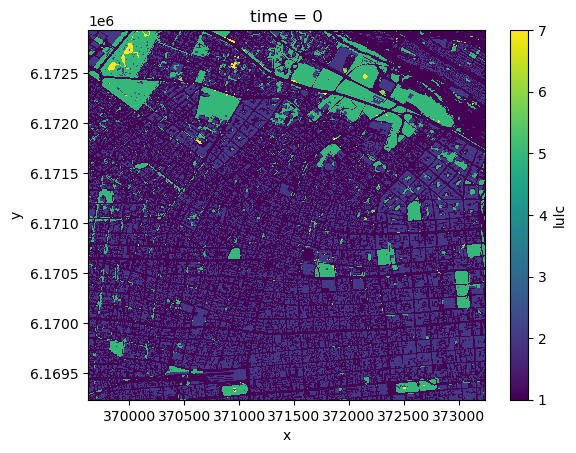

In [81]:
aoi_UrbanLandUse_to_solweig.plot()

In [68]:
# Create a table of the land use types and their counts from aoi_UrbanLandUse DataArray
land_use_counts_to_v2 = aoi_UrbanLandUse_to_v2.groupby(aoi_UrbanLandUse_to_v2).count().to_dataframe()
land_use_counts_to_v2

,time,lulc
lulc,,
1,0,496111
2,0,5609111
3,0,14559
4,0,1018821
5,0,29682
6,0,1477802
7,0,4616435
8,0,80519


In [78]:
# Create a table of the land use types and their counts from aoi_UrbanLandUse DataArray
land_use_counts_to_solweig = aoi_UrbanLandUse_test.groupby(aoi_UrbanLandUse_test).count().to_dataframe()
land_use_counts_test = land_use_counts_to_solweig

In [79]:
land_use_counts_test == land_use_counts_to_solweig

,time,lulc
lulc,,
1,True,True
2,True,True
5,True,True
6,True,True
7,True,True


In [80]:
# Save data to file
file_path = f'{file_path_prefix(aoi_name)}-UrbanLandUseV2.tif'
aoi_UrbanLandUse_to_solweig.rio.to_raster(raster_path=file_path, driver="COG")
print(f'File saved to {file_path}')

File saved to ./data/ba_roi/ba_roi-UrbanLandUseV2.tif


# High Resolution 1m Global Canopy Height Maps

https://gee-community-catalog.org/projects/meta_trees/


In [33]:
from city_metrix.layers import TreeCanopyHeight

# Load layer
aoi_TreeCanopyHeight = TreeCanopyHeight().get_data(aoi_gdf.total_bounds)

Extracting layer tree canopy height from Google Earth Engine for bbox [-58.42200867 -34.61043184 -58.38202589 -34.57761728]:
[########################################] | 100% Completed | 7.18 sms


In [34]:
aoi_TreeCanopyHeight.rio.resolution()

(1.0, 1.0)

In [35]:
# Save data to file
file_path = f'{file_path_prefix(aoi_name)}-TreeCanopyHeight.tif'
aoi_TreeCanopyHeight.rio.to_raster(raster_path=file_path, driver="COG")
print(f'File saved to {file_path}')

File saved to ./data/ba_roi/ba_roi-TreeCanopyHeight.tif


# Building footprints

In [36]:
from city_metrix.layers import OvertureBuildings

# Load layer
aoi_OvertureBuildings = OvertureBuildings().get_data(aoi_gdf.total_bounds)

In [37]:
# Save data to file
file_path = f'{file_path_prefix(aoi_name)}-OvertureBuildings.geojson'
aoi_OvertureBuildings.to_file(file_path, driver='GeoJSON')
print(f'File saved to {file_path}')


File saved to ./data/ba_roi/ba_roi-OvertureBuildings.geojson


# DSM

In [38]:
from city_metrix.layers import AlosDSM

aoi_AlosDSM = AlosDSM().get_data(aoi_gdf.total_bounds)

Extracting layer ALOS DSM from Google Earth Engine for bbox [-58.42200867 -34.61043184 -58.38202589 -34.57761728]:
[########################################] | 100% Completed | 633.15 ms


In [39]:
aoi_AlosDSM.rio.resolution()

(30.0, 30.0)

In [40]:
# Save data to file
file_path = f'{file_path_prefix(aoi_name)}-aoi_AlosDSM.tif'
aoi_AlosDSM.rio.to_raster(raster_path=file_path, driver="COG")
print(f'File saved to {file_path}')

File saved to ./data/ba_roi/ba_roi-aoi_AlosDSM.tif


In [41]:
from rasterio.enums import Resampling

dsm_1m = aoi_AlosDSM.rio.reproject(
            dst_crs=aoi_AlosDSM.rio.crs,
            resolution=1,
            resampling=Resampling.bilinear
        )

In [42]:
dsm_1m.rio.resolution()

(1.0, -1.0)

In [43]:
# Save data to file
file_path = f'{file_path_prefix(aoi_name)}-aoi_AlosDSM_1m.tif'
dsm_1m.rio.to_raster(raster_path=file_path, driver="COG")
print(f'File saved to {file_path}')

File saved to ./data/ba_roi/ba_roi-aoi_AlosDSM_1m.tif


# DEM

In [45]:
%autoreload
from city_metrix.layers import NasaDEM

aoi_NasaDEM = NasaDEM().get_data(aoi_gdf.total_bounds)


Extracting layer NASA DEM from Google Earth Engine for bbox [-58.42200867 -34.61043184 -58.38202589 -34.57761728]:
[########################################] | 100% Completed | 620.94 ms


In [46]:
aoi_NasaDEM.rio.resolution()

(30.0, 30.0)

In [47]:
# Save data to file
file_path = f'{file_path_prefix(aoi_name)}-aoi_NasaDEM.tif'
aoi_NasaDEM.rio.to_raster(raster_path=file_path, driver="COG")
print(f'File saved to {file_path}')

File saved to ./data/ba_roi/ba_roi-aoi_NasaDEM.tif


In [48]:
dem_1m = aoi_NasaDEM.rio.reproject(
            dst_crs=aoi_NasaDEM.rio.crs,
            resolution=1,
            resampling=Resampling.bilinear
        )

In [49]:
# Save data to file
file_path = f'{file_path_prefix(aoi_name)}-aoi_NasaDEM_1m.tif'
dem_1m.rio.to_raster(raster_path=file_path, driver="COG")
print(f'File saved to {file_path}')

File saved to ./data/ba_roi/ba_roi-aoi_NasaDEM_1m.tif


# Building height

In [50]:
aoi_height = aoi_AlosDSM - aoi_NasaDEM

In [52]:
from exactextract import exact_extract

aoi_OvertureBuildings = aoi_OvertureBuildings.to_crs(aoi_AlosDSM.rio.crs)

aoi_OvertureBuildings['AlosDSM_max'] = exact_extract(aoi_AlosDSM, aoi_OvertureBuildings, ["max"], output='pandas')['max']
aoi_OvertureBuildings['NasaDEM_max'] = exact_extract(aoi_NasaDEM, aoi_OvertureBuildings, ["max"], output='pandas')['max']
aoi_OvertureBuildings['height_max'] = exact_extract(aoi_height, aoi_OvertureBuildings, ["max"], output='pandas')['max']


In [54]:
aoi_OvertureBuildings

,id,version,update_time,sources,names,class,level,has_parts,height,min_height,num_floors,facade_color,facade_material,roof_material,roof_shape,roof_color,geometry,AlosDSM_max,NasaDEM_max,height_max
0,08bc2e311c822fff02000a6d3d5bbafd,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Google Open Bu...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((369637.084 6169235.232, 369634.146 6...",29.0,29.0,0.0
1,08bc2e311c822fff02008ffdd5c30a0d,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Google Open Bu...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((369645.403 6169240.352, 369642.233 6...",29.0,29.0,0.0
2,08bc2e311c822fff020044bd19a6b58b,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Google Open Bu...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((369651.142 6169243.140, 369653.104 6...",37.0,29.0,8.0
3,08bc2e311c822fff0200c84c3512c2eb,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Google Open Bu...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((369657.096 6169231.921, 369656.102 6...",37.0,29.0,8.0
4,08bc2e311c835fff020028bb7d2fe7aa,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Google Open Bu...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((369671.717 6169235.621, 369670.984 6...",37.0,29.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25582,08bc2e31a9859fff02001257a262a1ec,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Microsoft ML B...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((373220.406 6172829.853, 373239.451 6...",10.0,7.0,4.0
25583,08bc2e31a9ba4fff02006a6114cc4ec7,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Microsoft ML B...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((373192.933 6172847.646, 373198.890 6...",4.0,5.0,-1.0
25584,08bc2e31a9ba4fff0200dd7dd01b0cd1,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Google Open Bu...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((373214.337 6172850.257, 373205.031 6...",4.0,5.0,-1.0
25585,08bc2e31a9b10fff02005398d4b5a031,0,2024-04-06 07:00:00+00:00,"[ { ""property"": """", ""dataset"": ""Google Open Bu...",None,None,NaN,False,NaN,NaN,NaN,None,None,None,None,None,"POLYGON ((373086.563 6172880.563, 373077.840 6...",5.0,4.0,1.0


In [55]:
# Write to file
file_path = f'{file_path_prefix(aoi_name)}-BuildingHights.geojson'
aoi_OvertureBuildings.to_file(file_path, driver='GeoJSON')
print(f'File saved to {file_path}')

File saved to ./data/ba_roi/ba_roi-BuildingHights.geojson


In [ ]:

def rasterize_polygon(self, gdf, snap_to):
        if gdf.empty:
            raster = np.full(snap_to.shape, 0, dtype=np.int8)
            raster = xr.DataArray(raster, dims=snap_to.dims, coords=snap_to.coords)

            return raster.rio.write_crs(snap_to.rio.crs, inplace=True)

        raster = make_geocube(
            vector_data=gdf,
            measurements=["Value"],
            like=snap_to,
            fill=np.int8(0)
        ).Value

        return raster.rio.reproject_match(snap_to)










# ERA5